In [6]:
from pathlib import Path
DATA_DOWNLOAD_DIR = Path.home()

In [7]:
import glob
import os
import pandas as pd
from emg2pose.data import Emg2PoseSessionData
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
stages = sorted(glob.glob(os.path.join(DATA_DOWNLOAD_DIR, "emg2pose_dataset_mini/*.hdf5")))

stage = stages[15]
data = Emg2PoseSessionData(hdf5_path=stage)


metadata_df = pd.read_csv(DATA_DOWNLOAD_DIR / "emg2pose_dataset_mini/metadata.csv")
metadata_df.head(5)

,session,user,stage,start,end,side,filename,moving_hand,held_out_user,held_out_stage,split,generalization
0,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,ThumbsUpDownThumbRotationsCWCCWP,1.649400e+09,1.649400e+09,left,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,False,val,user
1,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,ThumbsUpDownThumbRotationsCWCCWP,1.649400e+09,1.649400e+09,right,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,False,val,user
2,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,HandClawGraspFlicks,1.649401e+09,1.649401e+09,left,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,False,val,user
3,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,HandClawGraspFlicks,1.649401e+09,1.649401e+09,right,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,False,val,user
4,2022-04-07-1649318400-8125c-cv-emg-pose-train@2,29ddab35d7,ShakaVulcanPeace,1.649401e+09,1.649401e+09,left,2022-04-07-1649318400-8125c-cv-emg-pose-train@...,both,True,True,val,user_stage


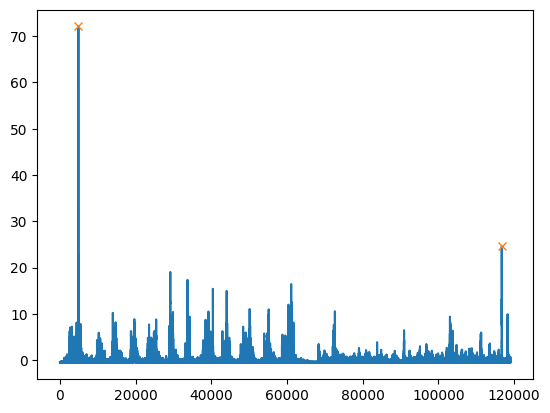

In [8]:
#for one
data = Emg2PoseSessionData(hdf5_path=stage)
channel = data['emg'].T[4]
channel = np.abs(channel)
channel = stats.zscore(channel)
#channel = channel[1500:3000]
plt.plot(channel)
peaks, _ = find_peaks(channel, prominence=20, distance=50)
plt.plot(peaks, channel[peaks], "x")

In [9]:
gesture_idx = dict() #{}
all_spikes = []
stage_instances = defaultdict(lambda: 0) #{countingUp: 0, countingDown: 4, ...} tracks what instance of particular gesture we're processing
stage_idx = dict()
stagei = 0
session_idx = dict()
sessioni = 1
subject_idx = dict()
subjecti = 1
for stage in stages:
    data = Emg2PoseSessionData(hdf5_path=stage) #one session
    start_time = data.metadata['start']
    stage = data.metadata['stage']
    if stage not in stage_idx.keys():
        stage_idx[stage] = stagei
        stagei += 1
    session = data.metadata['session']
    if session not in session_idx.keys():
        session_idx[session] = sessioni
        sessioni += 1
    subject = data.metadata['user']
    if subject not in subject_idx.keys():
        subject_idx[subject] = subjecti
        subjecti += 1
    semg_data = data['emg'].T
    stage_instance = stage_instances[stage]
    for channelIdx, channel in enumerate(semg_data):
        channel = np.abs(channel)
        channel = stats.zscore(channel)
        peaks, properties = find_peaks(channel, prominence=5, distance=50)
        for i, peak in enumerate(peaks):
            duration = (
                    data.__getitem__(properties["right_bases"][i])[0]
                    - data.__getitem__(properties["left_bases"][i])[0]
                )
            time_occur = data.__getitem__(peak)[0] - start_time
            spike_token = {
                "session": session_idx[session],
                "subject": subject_idx[subject],
                "channel": channelIdx+1,
                "prominence": round(properties["prominences"][i], 1),
                "duration": round(duration, 2),
                "time": time_occur,
                "instance": stage_instance,
                "gesture": stage_idx[stage],
            }
            all_spikes.append(spike_token)
    stage_instances[stage] += 1

with open("data/all_spikes.pickle", "wb") as handle:
    pickle.dump(all_spikes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("data/session_idx.pickle", "wb") as handle:
    pickle.dump(session_idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("data/stage_idx.pickle", "wb") as handle:
    pickle.dump(stage_idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("data/subject_idx.pickle", "wb") as handle:
    pickle.dump(subject_idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
import random
print(random.sample(all_spikes, 5))

[{'session': 1, 'subject': 1, 'channel': 11, 'prominence': 5.9, 'duration': 0.31, 'time': 43.2704861164093, 'instance': 0, 'gesture': 7}, {'session': 1, 'subject': 1, 'channel': 15, 'prominence': 5.3, 'duration': 0.4, 'time': 36.36315298080444, 'instance': 0, 'gesture': 10}, {'session': 1, 'subject': 1, 'channel': 8, 'prominence': 5.1, 'duration': 0.09, 'time': 37.302151918411255, 'instance': 1, 'gesture': 5}, {'session': 1, 'subject': 1, 'channel': 8, 'prominence': 7.7, 'duration': 0.87, 'time': 12.469759225845337, 'instance': 1, 'gesture': 8}, {'session': 1, 'subject': 1, 'channel': 8, 'prominence': 7.1, 'duration': 0.78, 'time': 1.9608540534973145, 'instance': 1, 'gesture': 10}]
